In [9]:
%cd ..

/Users/richard/proj


/Users/richard/.pyenv/versions/3.12.4/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
from utils import utils
import matplotlib.pyplot as plt
import pandas as pd
import contextily as cx
import numpy as np

data = pd.DataFrame(utils.load_data("alerts").data)

In [11]:
alerts = utils.extract_event(data, ['ACCIDENT']).drop("uuid", axis=1)

Error al leer el archivo


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
antof_grid = utils.grid(alerts, 10, 20)
antof_grid

In [ ]:
alerts_grouped = alerts.copy()
alerts_grouped["group"] = alerts_grouped.to_crs(epsg=3857).geometry.apply(
    lambda x: utils.calc_quadrant(
        *utils.get_quadrant(
            *antof_grid,
            (
                x.x,
                x.y,
            ),
        ),
        antof_grid[0].shape[1] - 1,
    ),
)   

In [5]:
alerts_grouped["group"].value_counts()

NameError: name 'alerts_grouped' is not defined

In [71]:
## Accidentes por grupo al día
grouped_day = (pd.DataFrame({"group": alerts_grouped.group.value_counts().keys(), "qty/day": alerts_grouped.group.value_counts().values / (alerts_grouped["inicio"].max() - alerts_grouped["inicio"].min()).days})).sort_values(ascending=False, by="qty/day")
grouped_day

,group,qty/day
0,96,1.380282
1,105,1.197183
2,114,0.957746
3,40,0.676056
4,50,0.619718
...,...,...
64,124,0.014085
65,44,0.014085
66,165,0.014085
67,159,0.014085


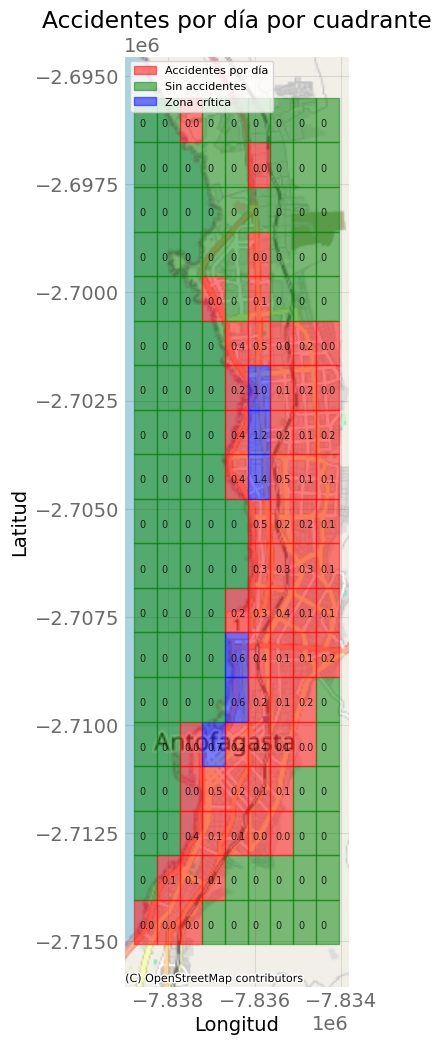

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        group_freq = np.float16(grouped_day[grouped_day["group"] == quad]["qty/day"])[0] if quad in grouped_day["group"].values else 0
        color = "r" if group_freq > 0 else "g"
        color = "b" if group_freq > 0.5 else color
        label = ""
        if group_freq == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True
        
        if group_freq > 0 and not labels[1] and label == "":
            label = "Accidentes por día"
            labels[1] = True

        if group_freq > 0.5 and not labels[2] and label == "":
            label = "Zona crítica"
            labels[2] = True

        ax.text(xp - 150, yp - 150, round(group_freq, 1), fontsize=7, alpha=0.8)
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(
    ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
)

plt.title("Accidentes por día por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.show()

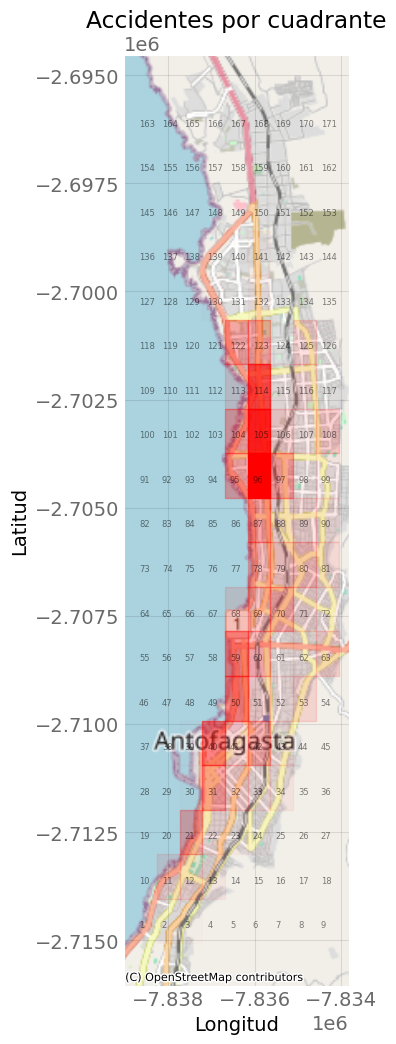

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (
                    alerts_grouped["group"].value_counts().max()
                    - alerts_grouped["group"].value_counts().min()
                )
            ) ,
            color="r"
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()

In [74]:
int(alerts_grouped.value_counts("group").reset_index()[alerts_grouped.value_counts("group").reset_index()["group"] == 132]["count"])

/var/folders/yx/rq7byh7s6351q7njcpzgf8_w0000gn/T/ipykernel_60779/3153385388.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  int(alerts_grouped.value_counts("group").reset_index()[alerts_grouped.value_counts("group").reset_index()["group"] == 132]["count"])


4

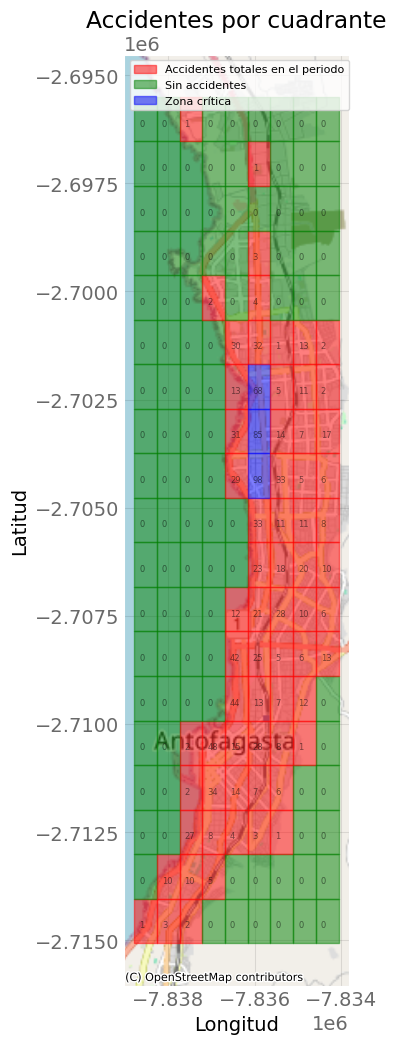

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
labels = [False, False, False]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)

        qty = (
            np.int16(
                alerts_grouped.value_counts("group").reset_index()[
                    alerts_grouped.value_counts("group").reset_index()["group"] == quad
                ]["count"]
            )[0]
            if quad
            in alerts_grouped.value_counts("group").reset_index()["group"].values
            else 0
        )

        color = "r" if qty > 0 else "g"
        color = "b" if qty > 60 else color
        label = ""
        if qty == 0 and not labels[0]:
            label = "Sin accidentes"
            labels[0] = True
        
        if qty > 0 and not labels[1] and label == "":
            label = "Accidentes totales en el periodo"
            labels[1] = True

        if qty > 60 and not labels[2] and label == "":
            label = "Zona crítica"
            labels[2] = True

        ax.text(
            xp - 150,
            yp - 150,
            qty,
            fontsize=6,
            alpha=0.5,
        )
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=0.5,
            color=color,
            label=label,
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(
    ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.legend(fontsize=8, loc="upper left")
plt.show()


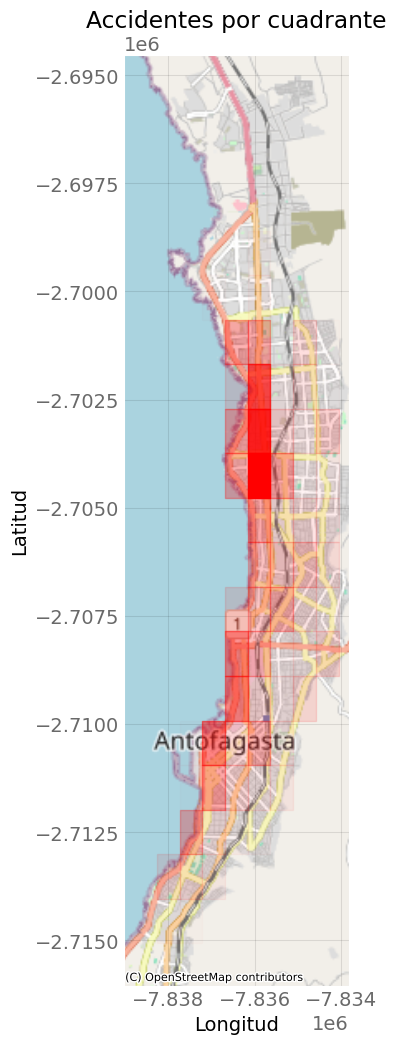

In [76]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))

xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        # ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (
                    alerts_grouped["group"].value_counts().max()
                    - alerts_grouped["group"].value_counts().min()
                )
            ) ,
            color="r"
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()

In [77]:
alerts_grouped

,street,inicio,fin,x,y,geometry,hour,minute,day,week_day,day_type,group
4,Irarrázaval,2024-08-23 11:12:19-04:00,2024-08-23 14:58:45-04:00,-70.385124,-23.603943,POINT (-7835236.163 -2705220.57),11,12,23,4,s,88
88,Díaz Gana,2024-08-23 14:34:02-04:00,2024-08-23 14:58:45-04:00,-70.403280,-23.665485,POINT (-7837257.28 -2712698.657),14,34,23,4,s,21
89,Av. Angamos,2024-08-23 14:33:40-04:00,2024-08-23 14:58:45-04:00,-70.403210,-23.665352,POINT (-7837249.487 -2712682.492),14,33,23,4,s,21
96,Av. Edmundo Pérez Zujovic,2024-08-23 14:43:35-04:00,2024-08-23 14:58:45-04:00,-70.396410,-23.628191,POINT (-7836492.515 -2708166.572),14,43,23,4,s,59
101,Av. Grecia,2024-08-23 15:29:55-04:00,2024-08-23 14:58:45-04:00,-70.402630,-23.654842,POINT (-7837184.922 -2711405.154),15,29,23,4,s,31
...,...,...,...,...,...,...,...,...,...,...,...,...
14714,Av. Edmundo Pérez Zujovic,2024-11-02 20:19:27-03:00,2024-11-02 23:23:53.487000-03:00,-70.396700,-23.572166,POINT (-7836524.798 -2701360.661),20,19,2,5,f,122
14718,Circunvalación Padre Alberto Hurtado,2024-11-02 20:32:24-03:00,2024-11-02 23:38:55.690000-03:00,-70.379570,-23.633654,POINT (-7834617.895 -2708830.372),20,32,2,5,f,62
14722,Circunvalación Padre Alberto Hurtado,2024-11-02 20:44:47-03:00,2024-11-02 23:48:57.172000-03:00,-70.378876,-23.633125,POINT (-7834540.639 -2708766.093),20,44,2,5,f,63
14729,Av. Angamos,2024-11-02 21:58:02-03:00,2024-11-03 01:04:08.111000-03:00,-70.404420,-23.667774,POINT (-7837384.184 -2712976.865),21,58,2,5,f,21


In [78]:
alerts_cleaned = alerts_grouped.drop(["street", "inicio", "fin", "x", "y", "geometry", "day"], axis=1)
alerts_cleaned

,hour,minute,week_day,day_type,group
4,11,12,4,s,88
88,14,34,4,s,21
89,14,33,4,s,21
96,14,43,4,s,59
101,15,29,4,s,31
...,...,...,...,...,...
14714,20,19,5,f,122
14718,20,32,5,f,62
14722,20,44,5,f,63
14729,21,58,5,f,21


In [79]:
results = utils.xgb_classifier(alerts_cleaned, "happen", ohe=False)


[0.83185841 0.87610619 0.85840708 0.78761062 0.88053097 0.83628319
 0.87168142 0.84955752 0.8539823  0.83628319]
0.8482300884955751


In [80]:
xgb = results["model"]

In [81]:
xgb.predict(results["X_test"])

array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,

In [82]:
results["X_train"]

,hour,minute,week_day,day_type,group
4420,15,17,2,1,96
8056,7,51,2,1,125
758,19,49,0,1,25
5764,2,15,4,0,60
5274,8,28,6,0,90
...,...,...,...,...,...
508,3,35,5,1,8
14283,14,44,0,1,32
0,21,34,0,1,97
164,15,35,1,0,28


In [83]:
day_type = 1
hour = 7
minute = 30
week_day = 3
group = 76

In [84]:
# Preparing a sample with the same structure as X_train_happen
obj = pd.DataFrame(columns=results["X_train"].columns)
obj.loc[0] = 0  # Initialize all values to 0

probs = []

# Set desired features
obj["day_type"] = day_type
obj["hour"] = hour
obj["minute"] = minute
obj["week_day"] = week_day
obj["group"] = group

prob_happen = xgb.predict_proba(obj)
prob_happen


array([[0.3644747, 0.6355253]], dtype=float32)

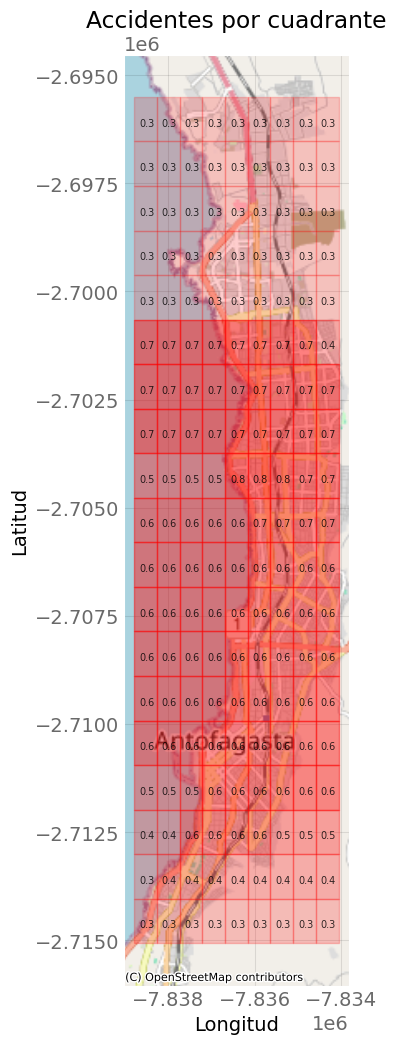

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches((4.5, 9.5))
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        obj["group"] = quad
        pred = xgb.predict_proba(obj)[0][1]
        ax.text(xp - 150, yp - 150, round(pred, 1), fontsize=7, alpha=0.8)
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=pred*0.7,
            color="r",
        )
        j += 1
    i += 1
    j = 0

cx.add_basemap(ax, crs=alerts_grouped.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()
    